In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_parquet('../data/cleaned-sgjobdata.parquet')
df.head()

,job_id,title,company,min_exp,positionlevels,posting_date,num_applications,num_views,num_vacancies,categories,average_salary,average_salary_cleaned
0,MCF-2023-0252866,Food Technologist - Clementi | Entry Level | U...,WORKSTONE PTE. LTD.,0,Executive,2023-03-30,5,151,1,"[{""id"":13,""category"":""Environment / Health""},{...",2400.0,2400.0
1,MCF-2023-0273977,"Software Engineer (Fab Support) (Java, CIM, Up...",TRUST RECRUIT PTE. LTD.,2,Executive,2023-04-08,0,55,2,"[{""id"":21,""category"":""Information Technology""}]",4750.0,4750.0
2,MCF-2023-0273994,Senior Technician,PU TIEN SERVICES PTE. LTD.,3,Senior Executive,2023-04-08,7,99,1,"[{""id"":33,""category"":""Repair and Maintenance""}]",4200.0,4200.0
3,MCF-2023-0273991,"Senior .NET Developer (.NET Core, MVC, MVVC, S...",TRUST RECRUIT PTE. LTD.,8,Senior Executive,2023-04-08,6,113,1,"[{""id"":21,""category"":""Information Technology""}]",7500.0,7500.0
4,MCF-2023-0273976,Sales / Admin Cordinator,EATZ CATERING SERVICES PTE. LTD.,2,Non-executive,2023-04-08,3,99,3,"[{""id"":2,""category"":""Admin / Secretarial""}]",2900.0,2900.0


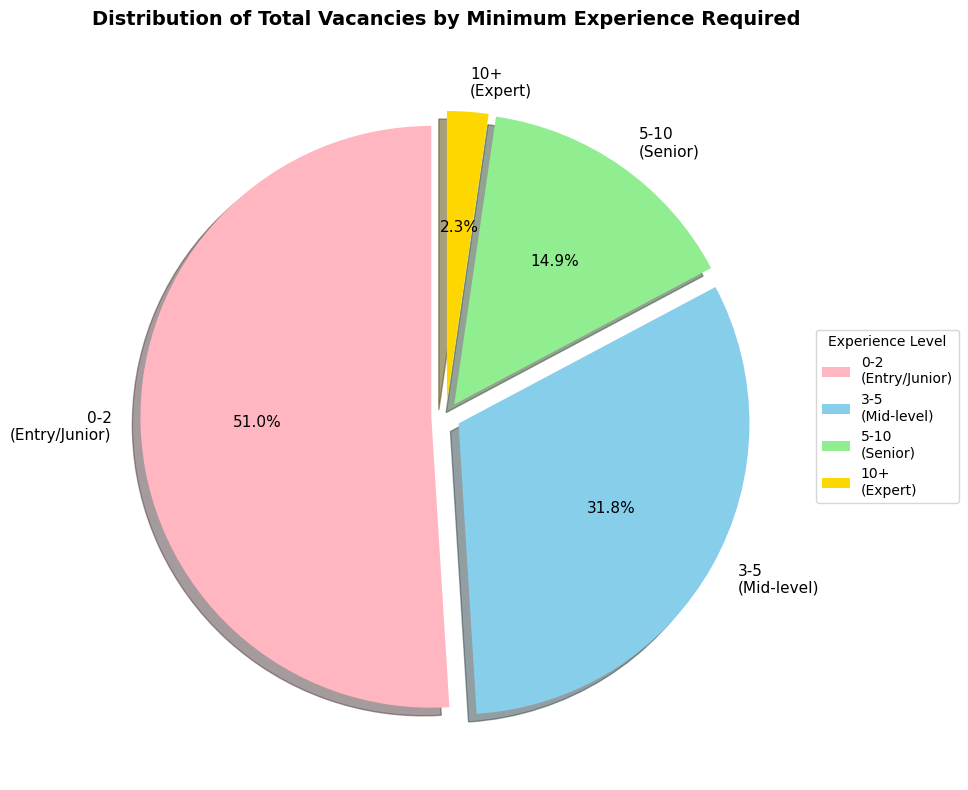


Total Number of Vacancies by Experience Group:
Experience Group     Total Vacancies      Percentage     
-------------------------------------------------------
0-2                  1432920                      50.99%
3-5                  893191                       31.78%
5-10                 419691                       14.93%
10+                  64451                         2.29%
-------------------------------------------------------
TOTAL                2810253             


In [9]:
# Create pie chart for total vacancies grouped by min_exp ranges
# Define experience groups
bins = [0, 2, 5, 10, float('inf')]
labels = ['0-2', '3-5', '5-10', '10+']

# Group min_exp and sum vacancies
df['exp_group'] = pd.cut(df['min_exp'], bins=bins, labels=labels, right=False)
vacancies_by_exp = df.groupby('exp_group')['num_vacancies'].sum()

# Create pie chart
plt.figure(figsize=(12, 8))
colors = ['#FFB6C1', '#87CEEB', '#90EE90', '#FFD700']
explode = (0.05, 0.05, 0.05, 0.05)

# Create labels with career level information
labels_with_level = ['0-2\n(Entry/Junior)', '3-5\n(Mid-level)', '5-10\n(Senior)', '10+\n(Expert)']

plt.pie(vacancies_by_exp, labels=labels_with_level, autopct='%1.1f%%', 
        startangle=90, colors=colors, explode=explode, shadow=True, textprops={'fontsize': 11})

plt.title('Distribution of Total Vacancies by Minimum Experience Required', fontsize=14, fontweight='bold', pad=20)
plt.legend(labels_with_level, title='Experience Level', loc='center left', bbox_to_anchor=(1, 0, 0.5, 1))
plt.tight_layout()
plt.show()

# Display detailed vacancy statistics
print("\n" + "="*80)
print("Total Number of Vacancies by Experience Group:")
print("="*80)
print(f"{'Experience Group':<20} {'Total Vacancies':<20} {'Percentage':<15}")
print("-" * 55)
total_all_vacancies = vacancies_by_exp.sum()
for group, vacancies in vacancies_by_exp.items():
    percentage = (vacancies / total_all_vacancies) * 100
    print(f"{group:<20} {int(vacancies):<20} {percentage:>13.2f}%")
print("-" * 55)
print(f"{'TOTAL':<20} {int(total_all_vacancies):<20}")

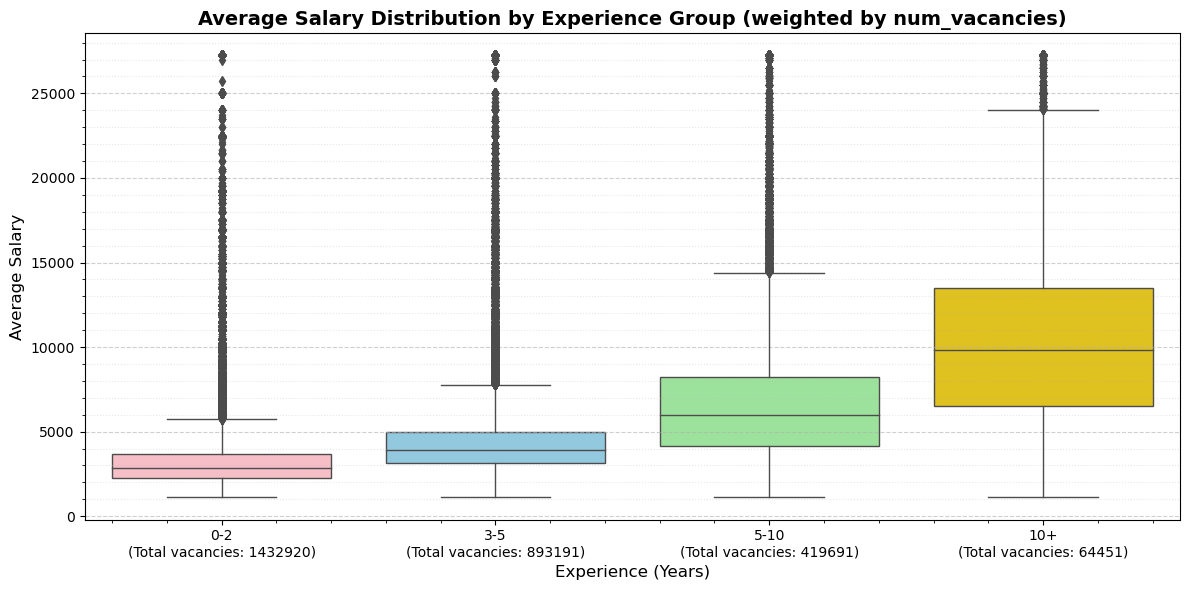


Weighted average salary statistics by experience group:
               count          mean          std     min     25%     50%  \
exp_group                                                                 
0-2        1108341.0   3111.717615  1535.711224  1110.0  2250.0  2850.0   
3-5         848778.0   4428.433575  2136.058356  1110.0  3150.0  3900.0   
5-10        405358.0   6717.040907  3245.791911  1110.0  4150.0  6000.0   
10+          59004.0  10322.462308  5104.046556  1110.0  6500.0  9800.0   

               75%      max  
exp_group                    
0-2         3650.0  27244.0  
3-5         5000.0  27244.0  
5-10        8250.0  27244.0  
10+        13500.0  27244.0  

Total vacancies by experience group:
exp_group
0-2     1432920
3-5      893191
5-10     419691
10+       64451
Name: num_vacancies, dtype: int64


In [10]:
# Weighted boxplots: min_exp groups with weighting by num_vacancies
# Define experience groups
bins = [0, 2, 5, 10, float('inf')]
labels = ['0-2', '3-5', '5-10', '10+']
colors = ['#FFB6C1', '#87CEEB', '#90EE90', '#FFD700']

# Ensure exp_group exists
if 'exp_group' not in df.columns:
    df['exp_group'] = pd.cut(df['min_exp'], bins=bins, labels=labels, right=False)

# Prepare data: expand rows by capping at max 20 vacancies per row (to avoid memory explosion)
# This creates a weighted representation
df_weighted = df.copy()
df_weighted['weight_cap'] = df_weighted['num_vacancies'].clip(upper=20)

# Create weighted dataframe by repeating rows
df_expanded = df_weighted.loc[df_weighted.index.repeat(df_weighted['weight_cap'].astype(int))].reset_index(drop=True)

# Drop rows with missing values
plot_df = df_expanded.dropna(subset=['exp_group', 'average_salary_cleaned']).copy()

# Compute total vacancies per group (from original, unweighted data)
vacancy_totals = df.groupby('exp_group')['num_vacancies'].sum()

# Create boxplot
plt.figure(figsize=(12, 6))
ax = sns.boxplot(data=plot_df, x='exp_group', y='average_salary_cleaned', palette=colors, linewidth=1)

# Create x-tick labels with total vacancies
xticklabels = [f"{grp}\n(Total vacancies: {int(vacancy_totals.get(grp, 0))})" for grp in labels]
ax.set_xticklabels(xticklabels)

# Labels, title and grid
ax.set_xlabel('Experience (Years)', fontsize=12)
ax.set_ylabel('Average Salary', fontsize=12)
ax.set_title('Average Salary Distribution by Experience Group (weighted by num_vacancies)', fontsize=14, fontweight='bold')
plt.grid(True, axis='y', which='major', linestyle='--', alpha=0.6)
plt.minorticks_on()
plt.grid(True, which='minor', axis='y', linestyle=':', alpha=0.3)
plt.tight_layout()
plt.show()

# Summary statistics
print('\nWeighted average salary statistics by experience group:')
print(plot_df.groupby('exp_group')['average_salary_cleaned'].describe())

print('\nTotal vacancies by experience group:')
print(vacancy_totals.astype(int))

In [11]:
# Summary check of vacancies
print("\n" + "="*80)
print("VACANCIES SUMMARY CHECK")
print("="*80)

# Overall vacancy statistics
total_vacancies = df['num_vacancies'].sum()
mean_vacancies = df['num_vacancies'].mean()
median_vacancies = df['num_vacancies'].median()
max_vacancies = df['num_vacancies'].max()
min_vacancies = df['num_vacancies'].min()
std_vacancies = df['num_vacancies'].std()

print(f"\nOverall Statistics:")
print(f"  Total Vacancies: {int(total_vacancies):,}")
print(f"  Mean Vacancies per Job: {mean_vacancies:.2f}")
print(f"  Median Vacancies per Job: {median_vacancies:.0f}")
print(f"  Min Vacancies: {min_vacancies:.0f}")
print(f"  Max Vacancies: {max_vacancies:.0f}")
print(f"  Std Dev: {std_vacancies:.2f}")
print(f"  Total Job Postings: {len(df):,}")

# Breakdown by experience group
print(f"\nVacancies by Experience Group:")
print("-" * 60)
vacancies_summary = df.groupby('exp_group')['num_vacancies'].agg(['sum', 'mean', 'median', 'min', 'max', 'count'])
vacancies_summary.columns = ['Total', 'Mean', 'Median', 'Min', 'Max', 'Job Count']
print(vacancies_summary.astype({'Total': 'int64', 'Job Count': 'int64'}))

# Percentage breakdown
print(f"\nPercentage of Total Vacancies by Experience Group:")
print("-" * 60)
for group in ['0-2', '3-5', '5-10', '10+']:
    group_total = df[df['exp_group'] == group]['num_vacancies'].sum()
    percentage = (group_total / total_vacancies) * 100
    print(f"  {group:<8} : {int(group_total):>10,} vacancies ({percentage:>6.2f}%)")


VACANCIES SUMMARY CHECK

Overall Statistics:
  Total Vacancies: 2,810,253
  Mean Vacancies per Job: 2.69
  Median Vacancies per Job: 1
  Min Vacancies: 1
  Max Vacancies: 999
  Std Dev: 11.26
  Total Job Postings: 1,044,597

Vacancies by Experience Group:
------------------------------------------------------------
             Total      Mean  Median  Min  Max  Job Count
exp_group                                                
0-2        1432920  3.785426     2.0    1  999     378536
3-5         893191  2.103219     1.0    1  999     424678
5-10        419691  2.041497     1.0    1  999     205580
10+          64451  1.800156     1.0    1  845      35803

Percentage of Total Vacancies by Experience Group:
------------------------------------------------------------
  0-2      :  1,432,920 vacancies ( 50.99%)
  3-5      :    893,191 vacancies ( 31.78%)
  5-10     :    419,691 vacancies ( 14.93%)
  10+      :     64,451 vacancies (  2.29%)
